# Notebook example

Lets start with importing some Python modules. The `acs` module can perform various operations on [American Community Survey](https://ctpp.transportation.org/2012-2016-5-year-ctpp/) (ACS) flow data, the `geo` module operates on geometric data (shape files), the `srtm` module can compute elevations from [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM) data, the `od` data works on origin-destination lines, the `dist` module provides distributions for mode share computations, the `cycle` module can retrieve route information from the Cycle Streets [website](https://www.cyclestreets.net/), and the `route` module works on route data.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
from stplanpy import acs
from stplanpy import geo
from stplanpy import srtm
from stplanpy import od
from stplanpy import dist
from stplanpy import cycle
from stplanpy import route

Flow data is read from the example [csv data file](https://raw.githubusercontent.com/pctBayArea/stplanpy/main/jupyter/od_data.csv) into a Pandas DataFrame using the `read_acs` function. The `clean_acs` function cleans up the data in the DataFrame. "home" is subtracted from "all", because people working from home do not make any trips. The category "Car, truck, or van -- Drove alone" is renamed to "sov", Single-occupancy Vehicle. Lastly, "active" transportation, "transit", and "carpool" columns are created. "orig_taz" and "dest_taz" are the origin and destination Traffic Analysis Zones (TAZ), respectively.

In [2]:
flow_data = acs.read_acs("od_data.csv")
flow_data = flow_data.clean_acs()

Next, county geography data is imported into a GeoDataFrame. The [County data](https://github.com/pctBayArea/stplanpy/blob/main/jupyter/ca-county-boundaries.zip?raw=true) used in this notebook can be found on Github. Other county and place shape files can be found on the [US census website](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html). Traffic Analysis Zone shape files can be found on [data.gov](https://catalog.data.gov/dataset/tiger-line-shapefile-2011-series-information-file-for-the-2010-census-traffic-analysis-zone-taz). Elevation data from the Shuttle Radar Topography Mission (SRTM) can be found on [nasa.gov](https://www2.jpl.nasa.gov/srtm/). Only San Franciso Bay Area Counties are kept.

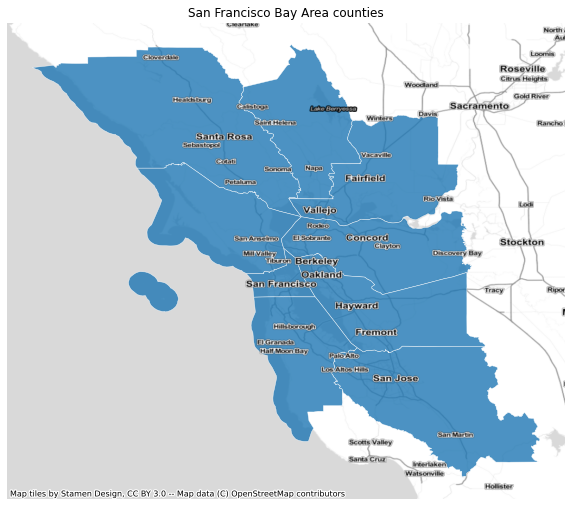

In [3]:
# Bay Area county codes
# 06 001 Alameda County
# 06 013 Contra Costa County
# 06 041 Marin County
# 06 055 Napa County
# 06 075 San Francisco County
# 06 081 San Mateo County
# 06 085 Santa Clara County
# 06 095 Solano County
# 06 097 Sonoma County
counties = ["001", "013", "041", "055", "075", "081", "085", "095", "097"]

# Read county data
county = geo.read_shp("ca-county-boundaries.zip")

# Keep only San Francisco Bay Area counties
county = county[county["countyfp"].isin(counties)]
 
# Select columns to keep
county = county[["name", "countyfp", "geometry"]]

# Plot data
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
county.plot(ax=ax, color="C0", alpha=0.8, edgecolor="white", linewidth=0.5)
ctx.add_basemap(ax, crs=county.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=county.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("San Francisco Bay Area counties")
plt.axis('off')
plt.show()

After importing the County geometry data, Census Designated Place data is imported. The [Place data](https://github.com/pctBayArea/stplanpy/blob/main/jupyter/tl_2020_06_place.zip?raw=true) used in this notebook can be found on Github. Only East Palo Alto, Palo Alto, and Stanford University are kept. The `in_county` function determines in which county different places are located.


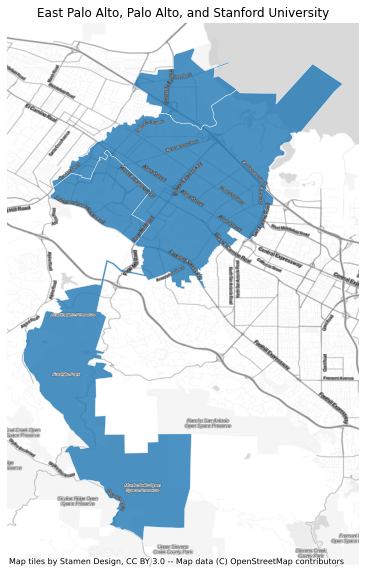

In [4]:
# Place codes
# 20956 East Palo Alto
# 55282 Palo Alto
# 73906 Stanford University
places = ["20956", "55282", "73906"]

# Read place data
place = geo.read_shp("tl_2020_06_place.zip")

# Keep only Stanford, Palo Alto, and East Palo Alto
place = place[place["placefp"].isin(places)]

# Compute which places lay inside which county
place = place.in_county(county)

# Select columns to keep
place = place[["name", "placefp", "countyfp", "geometry"]]

# Plot data
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
place.plot(ax=ax, color="C0", alpha=0.8, edgecolor="white", linewidth=0.5)
ctx.add_basemap(ax, crs=place.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=place.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("East Palo Alto, Palo Alto, and Stanford University")
plt.axis('off')
plt.show()

Lastly, Traffic Analysis Zone (TAZ) geometry data is imported and elevations are computed at the TAZ centroids. Some of the centroids are corrected to make sure that they are close to a road. This is needed for the routing between different zones below. The [TAZ data](https://github.com/pctBayArea/stplanpy/blob/main/jupyter/tl_2011_06_taz10.zip?raw=true) and [SRTM data](https://github.com/pctBayArea/stplanpy/blob/main/jupyter/srtm_12_05.zip?raw=true)
used in this notebook can be found on Github. The `in_place` function determines in which place a TAZ is located.

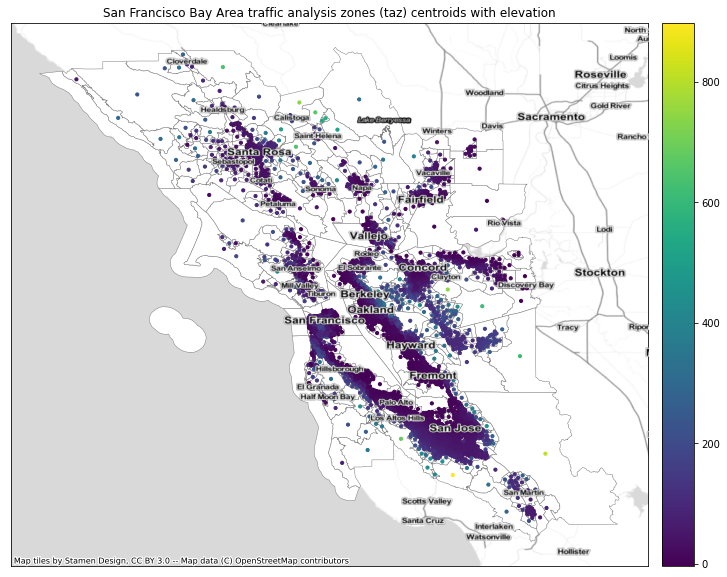

In [5]:
# Read taz data
taz = geo.read_shp("tl_2011_06_taz10.zip")

# Rename columns for consistency
taz.rename(columns = {"countyfp10":"countyfp", "tazce10":"tazce"}, inplace = True) 

# Filter on county codes
taz = taz[taz["countyfp"].isin(counties)]

# Compute centroids
taz_cent = taz.cent()

# Correct centroid locations so they are close to a road
# Google plex
taz_cent.corr_cent("00101155", -122.078052, 37.423328)
# Stanford research park
taz_cent.corr_cent("00100480", -122.145124, 37.407136)
# Facebook
taz_cent.corr_cent("00102130", -122.148703, 37.484923)
# San Antonio watershed
taz_cent.corr_cent("00103321", -121.845271, 37.602841)
# Tesla
taz_cent.corr_cent("00103023", -121.949050, 37.502547)
# Hayward
taz_cent.corr_cent("00103112", -122.122513, 37.622984)
# Pacifica 
taz_cent.corr_cent("00102160", -122.483845, 37.611063)
# Gilroy
taz_cent.corr_cent("00101057", -121.5119226,37.025154)

# Compute which taz lay inside a place and which part
taz = taz.in_place(place)

# Compute elevations
taz_cent = taz_cent.elev("srtm_12_05.zip")

# Plot data
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title("San Francisco Bay Area traffic analysis zones (taz) centroids with elevation")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
taz.plot(ax=ax, color="white", edgecolor="gray", linewidth=0.5)
taz_cent.plot(ax=ax, column="elevation", markersize=10, legend=True, cax=cax)
ctx.add_basemap(ax, crs=taz.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=taz.crs, source=ctx.providers.Stamen.TonerLabels)
plt.show()

Now the `orig_dest` function adds origin and destination county and place codes do the `flow_data` DataFrame. The `od_lines` function adds origin-destination lines. The `go_dutch` function computes the bicycle mode share if people biked as much as people in the Netherlands do, corrected for distance and hillyness.

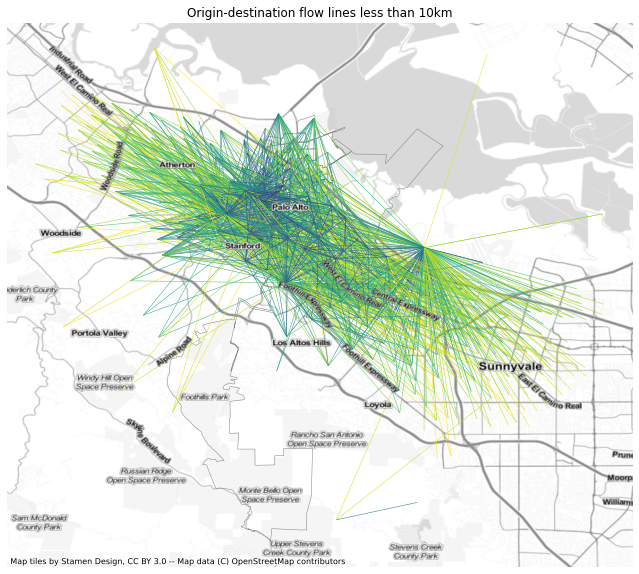

In [6]:
# Add county and place codes to data frame. This data is used to compute mode share in counties and places
flow_data = flow_data.orig_dest(taz)

# Compute origin-destination lines, distances, and gradient
flow_data["geometry"] = flow_data.od_lines(taz_cent)
flow_data["distance"] = flow_data.distances()
flow_data["gradient"] = flow_data.gradient(taz_cent)

# Compute go_dutch scenario
flow_data["go_dutch"] = flow_data.go_dutch()

# Plot origin destination lines for distances less than 10km
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
flow_data.loc[flow_data["distance"] <= 10000].plot(ax=ax, column="distance", linewidth=0.5)
ctx.add_basemap(ax, crs=flow_data.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=flow_data.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("Origin-destination flow lines less than 10km")
plt.axis('off')
plt.show()

The `mode_share` function computes the mode share for Traffic Analysis Zones and places. The `bike10` column contains the bicycle mode share for trips shorter than 10km (6 miles) and `go_dutch10` the mode share for the "Go Dutch" scenario.

In [ ]:
# Compute "bike", and "go_dutch" mode shares
taz[["bike", "go_dutch", "all"]] = taz.mode_share(flow_data)
place[["bike", "go_dutch", "all"]] = place.mode_share(flow_data)

# Compute mode share for trips shorter than 7.5km (4.5 miles)
taz[["bike75", "go_dutch75", "all75"]] = taz.mode_share(flow_data.loc[flow_data["distance"] <= 7500])
place[["bike75", "go_dutch75", "all75"]] = place.mode_share(flow_data.loc[flow_data["distance"] <= 7500])

# Plot data
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].plot(ax=ax, column="bike", alpha=0.8, edgecolor='gray', linewidth=0.5, legend=True)
ctx.add_basemap(ax, crs=taz.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=taz.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("Bicycle mode share of traffic analysis zones in East Palo Alto, Palo Alto, and Stanford Univeristy")
plt.axis('off')
plt.show()

# Show mode shares
print(place[["name", "bike", "go_dutch", "bike75", "go_dutch75", "all", "all75"]])

The `route_lines` function computes the routes between Traffic Analysis Zones using the Cycle Streets routing engine. The `directness` function divides the length of a route by the length of the equivalend origin-destination line. 

In [ ]:
# Remove TAZ without a cycling route
flow_data = flow_data.rm_taz("00103321")

# Read the Cycle Streets API key
cyclestreets_key = cycle.read_key()

# Compute routes
flow_data["geometry"] = flow_data.routes(api_key=cyclestreets_key)

# Compute distances, gradients, and directness 
flow_data["distance"] = flow_data.distances()
flow_data["gradient"] = flow_data.gradient(taz_cent)
flow_data["directness"] = flow_data.directness()

# Compute go_dutch scenario
flow_data["go_dutch"] = flow_data.go_dutch()

# Plot routes
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
taz.loc[taz["placefp"].isin(places)].boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
flow_data.plot(ax=ax, column="directness", linewidth=0.5, legend=True)
ctx.add_basemap(ax, crs=flow_data.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=flow_data.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("All bicycle routes")
plt.axis('off')
plt.show()

The `network` function combines all the different routes in a GeoDataFrame and reduces them to a single network. At each segment where routes overlap individual modes of transportation are summed up. Here the East Palo Alto network is computed. The line width is set by the "Go dutch" scenario.

In [ ]:
# Place codes
# 20956 East Palo Alto
# 55282 Palo Alto
# 73906 Stanford University
epa_network = flow_data.to_frm("20956").network()

# Compute linewidth
epa_network["width"] = 1+15*epa_network["go_dutch"]/epa_network["go_dutch"].max()

# Plot network
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
ax.set_xlim([-11787000,-11781500])
ax.set_ylim([4451500, 4456000])
taz.loc[taz["placefp"] == "20956"].boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
place.loc[place["placefp"] == "20956"].boundary.plot(ax=ax, edgecolor="black", linewidth=2.5)
epa_network.plot(ax=ax, linewidth=epa_network["width"])
ctx.add_basemap(ax, crs=epa_network.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=epa_network.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("Bicycle routes to and from East Palo Alto under the 'Go Dutch' scenario")
plt.axis('off')
plt.show()

The Palo Alto network.

In [ ]:
# Place codes
# 20956 East Palo Alto
# 55282 Palo Alto
# 73906 Stanford University
pa_network = flow_data.to_frm("55282").network()

# Compute linewidth
pa_network["width"] = 1+15*pa_network["go_dutch"]/pa_network["go_dutch"].max()

# Plot network
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
ax.set_xlim([-11789869,-11780640])
ax.set_ylim([4446000, 4454000])
taz.loc[taz["placefp"] == "55282"].boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
place.loc[place["placefp"] == "55282"].boundary.plot(ax=ax, edgecolor="black", linewidth=2.5)
pa_network.plot(ax=ax, linewidth=pa_network["width"])
ctx.add_basemap(ax, crs=pa_network.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=pa_network.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("Bicycle routes to and from Palo Alto under the 'Go Dutch' scenario")
plt.axis('off')
plt.show()

The Stanford University network.

In [ ]:
# Place codes
# 20956 East Palo Alto
# 55282 Palo Alto
# 73906 Stanford University
su_network = flow_data.to_frm("73906").network()

# Compute linewidth
su_network["width"] = 1+15*su_network["bike"]/su_network["bike"].max()

# Plot network
fig, ax = plt.subplots(figsize=(16,10))
ax.set_aspect("equal")
ax.set_xlim([-11790000,-11784000])
ax.set_ylim([4448000, 4452000])
taz.loc[taz["placefp"] == "73906"].boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
place.loc[place["placefp"] == "73906"].boundary.plot(ax=ax, edgecolor="black", linewidth=2.5)
su_network.plot(ax=ax, linewidth=su_network["width"])
ctx.add_basemap(ax, crs=su_network.crs, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(ax, crs=su_network.crs, source=ctx.providers.Stamen.TonerLabels)
plt.title("Bicycle routes to and from Stanford University under current mode share")
plt.axis('off')
plt.show()